[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/19ciN8LDEiin1H3ajYAcViobKBd9UOD2a)

# Analisis dan Peramalan Harga Crude Oil WTI Menggunakan Model ARIMA

Tujuan Notebook:

1. Memuat dan membersihkan data harga Crude Oil WTI.
2. Melakukan analisis eksplorasi (EDA) untuk memahami karakteristik deret waktu.
3. Mengidentifikasi dan menguji stasioneritas data.
4. Menerapkan dan mengevaluasi model ARIMA untuk peramalan.
5. Melakukan diagnostik residual untuk memeriksa asumsi model dan mengidentifikasi area untuk perbaikan.
6. Membandingkan hasil peramalan model ARIMA dengan data aktual.

Dari EDA sebelumnya kita sudah memperoleh

### 1. Data Bersih dan Siap Digunakan
- Dataset Crude Oil WTI telah berhasil dimuat dengan benar dan kolom tanggal (`date`) sudah dikonversi ke tipe data datetime.
- Tidak ditemukan adanya nilai yang hilang (NaN), sehingga data cukup lengkap untuk analisis deret waktu dalam rentang tanggal **2022-01-03** hingga **2024-09-30**.

### 2. Keberadaan Tren dan Variansi Tidak Konstan
- Visualisasi plot harga terhadap waktu dengan jelas menunjukkan adanya **tren yang berubah-ubah** di berbagai periode, tidak menunjukkan pola pertumbuhan atau penurunan yang stabil secara keseluruhan.
- Analisis lebih lanjut, termasuk observasi visual pada periode harga tinggi vs. rendah, mengindikasikan adanya **variansi yang tidak konstan (heteroskedastisitas)**, di mana fluktuasi harga cenderung lebih besar saat harga berada pada level yang lebih tinggi.

### 3. Konfirmasi Non-Stasioneritas Melalui Uji ADF
- Untuk mengkonfirmasi observasi visual, kita melakukan Uji Augmented Dickey-Fuller (ADF) pada deret waktu harga asli.
- Hasil uji ADF menunjukkan p-value sebesar **0.564115927289219**. Karena nilai ini **Lebih besar** dari tingkat signifikansi umum 0.05, kita **Gagal menolak** hipotesis nol.
- **Kesimpulan:** Uji ADF secara statistik mengkonfirmasi bahwa deret waktu harga Crude Oil WTI asli **kemungkinan non-stasioner**.

### 4. Stasionerisasi yang Berhasil dengan Differencing
- Sebagai respons terhadap non-stasioneritas, kita melakukan differencing orde pertama pada deret waktu harga.
- Uji ADF kembali dilakukan pada deret waktu yang telah didifferencing.
- Hasil uji ADF pada data yang didifferencing menunjukkan p-value sebesar **8.777759270918779e-23**. Karena nilai ini **Lebih kecil** dari 0.05, kita **Menolak** hipotesis nol.
- **Kesimpulan:** Deret waktu harga Crude Oil WTI setelah differencing orde pertama **kemungkinan stasioner**. Ini menetapkan orde differencing (d) untuk model ARIMA menjadi 1.

### 5. Struktur Autokorelasi dalam Data Stasioner
- Analisis visual melalui plot Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF) dari deret waktu yang telah didifferencing memberikan wawasan tentang pola korelasi sisa yang dapat dimodelkan.
- Plot ACF menunjukkan batang signifikan pada lag awal yang kemudian cut off.
- Plot PACF menunjukkan batang signifikan pada lag awal yang kemudian cut off.
- Pola-pola ini akan menjadi panduan penting dalam menentukan ordo autoregressive (p) dan moving average (q) dari model ARIMA.

#### Import Package dan Dataset

In [ ]:
# Import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Read dataframe
df = pd.read_csv('https://raw.githubusercontent.com/zakizulham/proyek-peramalan-global-comodity-price-september-2024/refs/heads/main/data/Arkavidiaa_Processed/Global_Commodity_Price/Crude_Oil_WTI.csv', parse_dates=['date'])

In [ ]:
# pastikan tipe data nya dalam keadaan benar semua
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      725 non-null    datetime64[ns]
 1   price     725 non-null    float64       
 2   open      725 non-null    float64       
 3   high      725 non-null    float64       
 4   low       725 non-null    float64       
 5   vol-k     725 non-null    float64       
 6   change-%  725 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 39.8 KB


In [ ]:
# sort dahulu sesuai date agar ascending
df.sort_values(by='date', inplace=True)

In [ ]:
# Atur kolom 'date' sebagai indeks DataFrame
df.set_index('date', inplace=True)

In [ ]:
# pilih kolom target
target_column = 'price'

Berdasarkan dari EDA kita mengetahui bahwa frequensi Minyak Mentah ini di observasi Harian. Sehingga, kita definisikan dahulu dengan date sebagai index dan frequensi sebagai Harian.

In [ ]:
# Atur frequency Harian 'D'
df = df.asfreq('D')

Meskipun begitu, observasi data kita tidak lengkap. Ada hari dimana tidak terobservasi.

In [ ]:
df.isna().sum()

,0
price,277
open,277
high,277
low,277
vol-k,277
change-%,277


Kita akan isi kosong hari tersebut khusus untuk kolom `price` yang kita butuhkan dengan `forward fill`

In [ ]:
# Atasi dengan backward fill
df = df.bfill()

# cara lain bisa menggunakan `interpolate` atau `forward` fill. Tapi khusus ini
# kita tetap akan gunakan `backward` fill
# df[target_column] = df[target_column].interpolate() # interpolate
# df = df.ffill() # forward

### Pemodelan ARIMA

Berdasarkan temuan kunci dari EDA ini, terutama konfirmasi non-stasioneritas yang berhasil diatasi dengan differencing (d=1) dan analisis struktur autokorelasi sisa melalui plot ACF/PACF, kita sekarang siap untuk melanjutkan ke section pemodelan.

Pada section ini, kita akan:

1.  **Menentukan Ordo (p, q) Model ARIMA:** Menggunakan plot ACF dan PACF dari data yang stasioner untuk mengidentifikasi ordo p (autoregressive) dan q (moving average) yang paling sesuai.
2.  **Membagi Data Latih dan Data Uji (Time Series Split):** Membagi data berdasarkan waktu untuk mensimulasikan skenario dunia nyata.
3.  **Menerapkan Model ARIMA:** Membangun dan melatih model ARIMA(p, 1, q) menggunakan pustaka `statsmodels`.
4.  **Mengevaluasi Kinerja Model:** Melakukan diagnostik pada residual model untuk memastikan asumsi model terpenuhi.
5.  **Melakukan Peramalan (Forecasting):** Menggunakan model yang telah dilatih untuk memprediksi harga Crude Oil WTI di masa depan.

#### 1. Menentukan Ordo (p, q) Model ARIMA

Berdasarkan analisis ACF dan PACF dari data yang telah didifferencing, kita perlu mengidentifikasi ordo p (autoregressive) dan q (moving average).

- Plot ACF membantu menentukan ordo $q$. Cari lag di mana fungsi autokorelasi secara signifikan cut off ke nol.
- Plot PACF membantu menentukan ordo $p$. Cari lag di mana fungsi autokorelasi parsial secara signifikan cut off ke nol.

Proses ini akan memerlukan beberapa percobaan dan evaluasi model yang berbeda.


**Untuk menampilkan plot ACF dan PACF dari data yang didifferencing:**

Pertama, kita perlu membuat deret waktu yang sudah didifferencing.

In [ ]:
# Membuat deret waktu yang sudah didifferencing orde pertama
df_diff = df[target_column].diff().dropna()

Sekarang kita bisa menampilkan plot ACF dan PACF dari `df_diff`.


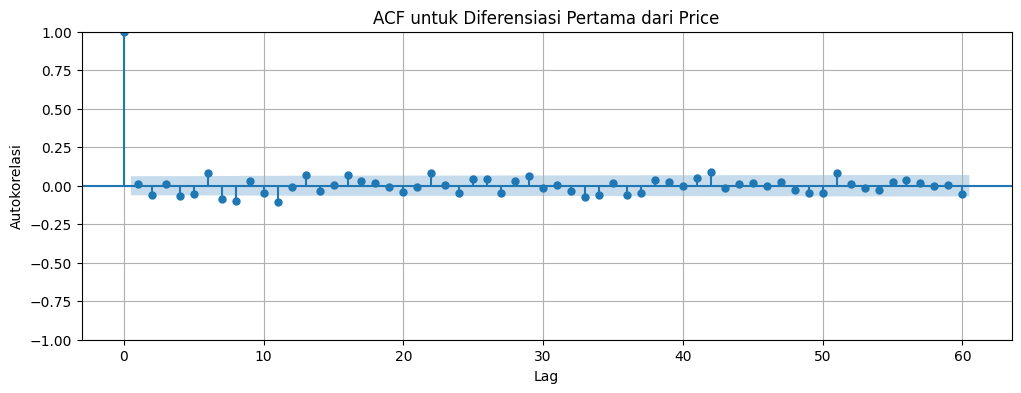

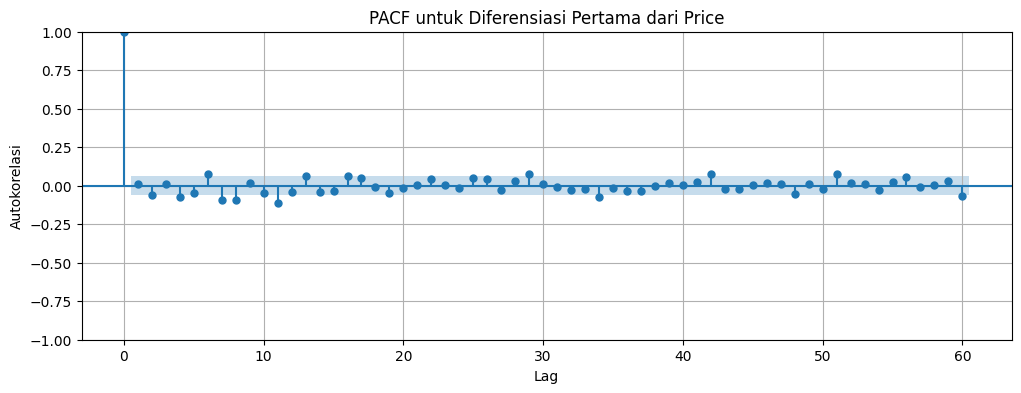

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(df_diff, lags=60,ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced Data')
plt.title(f'ACF untuk Diferensiasi Pertama dari Price')
plt.xlabel('Lag')
plt.ylabel('Autokorelasi')
plt.grid(True)
plt.show()

print()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(df_diff, lags=60,ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced Data')
plt.title(f'PACF untuk Diferensiasi Pertama dari Price')
plt.xlabel('Lag')
plt.ylabel('Autokorelasi')
plt.grid(True)
plt.show()
plt.show()


Sebelumnya kita sudah **Konfirmasi Non-Stasioneritas Melalui Uji ADF**

- Untuk mengkonfirmasi observasi visual, kita melakukan Uji Augmented Dickey-Fuller (ADF) pada deret waktu harga asli.
- Hasil uji ADF menunjukkan p-value sebesar **0.564115927289219**. Karena nilai ini **Lebih besar** dari tingkat signifikansi umum 0.05, kita **Gagal menolak** hipotesis nol.
- **Kesimpulan:** Uji ADF secara statistik mengkonfirmasi bahwa deret waktu harga Crude Oil WTI asli **kemungkinan non-stasioner**.

**Stasionerisasi yang Berhasil dengan Differencing**
- Sebagai respons terhadap non-stasioneritas, kita melakukan differencing orde pertama pada deret waktu harga.
- Uji ADF kembali dilakukan pada deret waktu yang telah didifferencing.
- Hasil uji ADF pada data yang didifferencing menunjukkan p-value sebesar **8.777759270918779e-23**. Karena nilai ini **Lebih kecil** dari 0.05, kita **Menolak** hipotesis nol.
- **Kesimpulan:** Deret waktu harga Crude Oil WTI setelah differencing orde pertama **kemungkinan stasioner**. Ini menetapkan orde differencing (d) untuk model ARIMA menjadi 1.

Berdasarkan plot ACF dan PACF di atas, kita dapat mengestimasi nilai awal untuk $p$ dan $q$. Karena ACF cut off setelah lag 1 dan PACF cut off setelah lag 1, maka ordo $(p,d,q)$ awal yang bisa dicoba adalah $(1,1,1)$.


Visualisasi Deret waktu yang terdiferensiasi

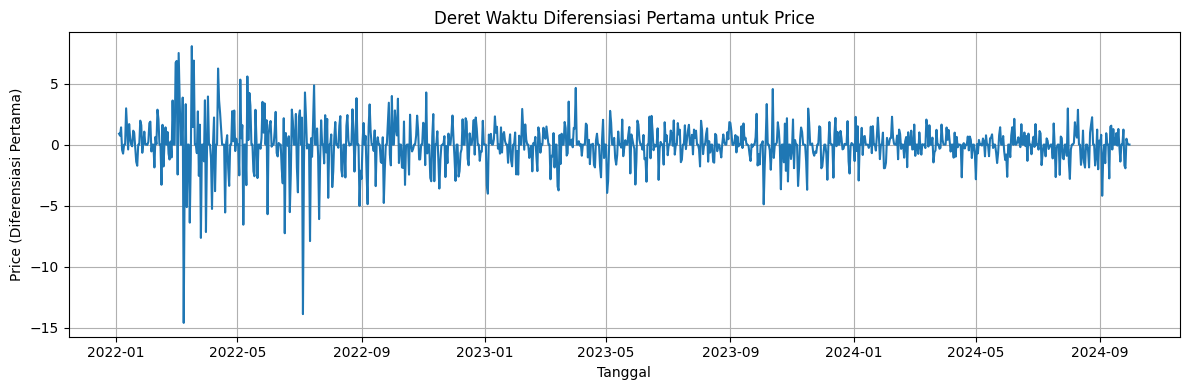

In [ ]:
# --- Visualisasi Deret Waktu yang Diferensiasi ---
plt.figure(figsize=(12, 4))
plt.plot(df_diff.index, df_diff)
plt.title('Deret Waktu Diferensiasi Pertama untuk Price')
plt.xlabel('Tanggal')
plt.ylabel('Price (Diferensiasi Pertama)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2. Membagi Data Latih dan Data Uji (Time Series Split)

Dalam pemodelan runtun waktu, pembagian data menjadi data latih (training) dan data uji (testing) harus dilakukan dengan hati-hati untuk menghindari _data leakage_. Data uji harus selalu merupakan periode waktu setelah data latih.

Ada beberapa pendekatan umum untuk membagi data runtun waktu:

1.  **Fixed Split:** Memilih titik potong tunggal dalam deret waktu. Data sebelum titik potong digunakan untuk pelatihan, dan data setelahnya digunakan untuk pengujian. Ini adalah metode yang paling sederhana dan sering digunakan.
2.  **Rolling Forecast Origin (Walk-Forward Validation):** Melatih model pada periode awal data, melakukan peramalan untuk periode berikutnya, lalu menggabungkan data aktual dari periode yang baru diramalkan ke dalam data latih dan mengulangi prosesnya. Ini mensimulasikan skenario di mana model terus diperbarui dengan data baru.
3.  **Time Series Cross-Validation:** Mirip dengan _k-fold cross-validation_ tetapi menjaga urutan waktu. Data dibagi menjadi beberapa _fold_, di mana setiap _fold_ uji datang setelah _fold_ latih yang sesuai.


**Menggunakan Metode Fixed Split:**

Kita akan menggunakan metode _fixed split_ untuk demonstrasi ini, membagi data menjadi data latih (sebelum tanggal 1 Januari 2024) dan data uji (tanggal 1 januari 2024 sampai akhir data ini yakni 30 September 2024).

Pada makna bisnis yang disimulasikan seperti client ingin mengetahui harga `minyak mentah` pada tahun 2024. Dari informasi data yakni dari 2022 sampai 2023.


In [ ]:
# Tentukan tanggal atau indeks untuk membagi data
split_date = '2024-01-01'

# Pembagian data berdasarkan indeks
data_latih = df.iloc[df.index < split_date].copy()
data_uji = df.iloc[df.index >= split_date].copy()

print(f"Dataset asli memiliki {len(df)} baris.")
print(f"Data latih: {len(data_latih)} baris (hingga {data_latih.index[-1] if not data_latih.empty else 'kosong'}).")
print(f"Data uji: {len(data_uji)} baris (dari {data_uji.index[0] if not data_uji.empty else 'kosong'} hingga {data_uji.index[-1] if not data_uji.empty else 'kosong'}).")


Dataset asli memiliki 1002 baris.
Data latih: 728 baris (hingga 2023-12-31 00:00:00).
Data uji: 274 baris (dari 2024-01-01 00:00:00 hingga 2024-09-30 00:00:00).


Visualisasi

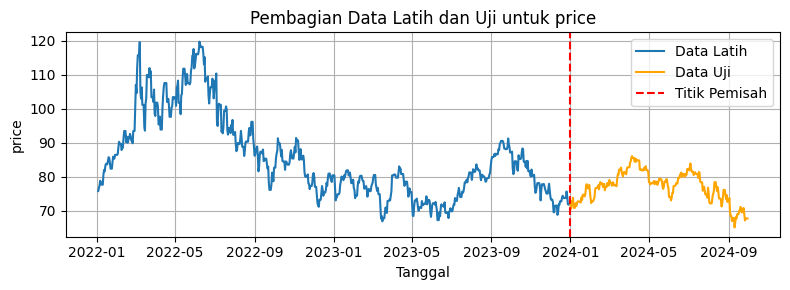

In [ ]:
# Visualisasikan pembagian data
plt.figure(figsize=(8, 3))
plt.plot(data_latih.index, data_latih[target_column], label='Data Latih')
plt.plot(data_uji.index, data_uji[target_column], label='Data Uji', color='orange')
plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', label='Titik Pemisah')
plt.title(f'Pembagian Data Latih dan Uji untuk {target_column}')
plt.xlabel('Tanggal')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3. Menerapkan Model ARIMA

Setelah menentukan ordo $(p,d,q)$ yang potensial, kita akan membangun dan melatih model ARIMA menggunakan pustaka `statsmodels`. Berdasarkan analisis sebelumnya, kita sudah menetapkan $d=1$. Kita akan menggunakan contoh ordo $(1,1,1)$ berdasarkan plot ACF/PACF yang telah kita tampilkan.


In [ ]:
# Definisikan ordo (p, d, q) berdasarkan analisis ACF/PACF
p = 1
d = 1
q = 1

# Buat model ARIMA menggunakan DATA LATIH
model = ARIMA(data_latih[target_column], order=(p,d,q))

# Latih model
model_fit = model.fit()

# Tampilkan ringkasan model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  728
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1537.283
Date:                Wed, 11 Jun 2025   AIC                           3080.567
Time:                        05:21:39   BIC                           3094.333
Sample:                    01-03-2022   HQIC                          3085.879
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5484      0.412     -1.332      0.183      -1.355       0.258
ma.L1          0.5894      0.395      1.494      0.135      -0.184       1.363
sigma2         4.0197      0.101     39.840      0.0

Dari ringkasan model (`model_fit.summary()`) kita dapat mengambil insight:

- **Signifikansi Parameter**:
  - Koefisien AR(1) dari `ar.L1` menunjukkan tidak signifikan secara statistik (`0.183` > `0.05`)
  - Koefisien MA(1) dari `ma.L1` menunjukkan tidak signifikan secara statistik (`0.135` > `0.05`)

- **Residual Autocorrelation**:
  - Residualnya mendekati white noise (`0.57` > `0.05`).
  - Model telah berhasil menangkap korelasi dalam data.

- **Residual Heteroskedasticity**:
  - Ada bukti bahwa adanya heteroskedastisitas pada residual (`0.00` < `0.05`). Ini mendukung visualisasi yang dilakukan sebelumnya di **EDA**.
  - Hal ini mengindikasikan Model ARIMA dasar ini mungkin memiliki keterbatasan dalam menangani fluktuasi variabilitas, menguatkan alasan di **EDA** untuk mempertimbangkan transformasi atau **ARCH/GARCH**

- **Residual Normality**:
  - Residual tidak berdistribusi secara normal (`0.00` < `0.05`). Sehingga, asumsi normalitas residual tidak terpenuhi.

Bandingkan dengan kombinasi yang lain

In [ ]:
# Kombinasi bandingkan (p,d,q) yang lain
# untuk model (p,d,q)
# model: (1,1,1)
# model1: (1,1,2)
# model2: (2,1,1)
# model3: (2,1,2)
# model4: (0,1,1)
# model5: (1,1,0)


# Buat kombinasi model ARIMA menggunakan DATA LATIH
model1 = ARIMA(data_latih[target_column], order=(1,1,2))
model2 = ARIMA(data_latih[target_column], order=(2,1,1))
model3 = ARIMA(data_latih[target_column], order=(2,1,2))
model4 = ARIMA(data_latih[target_column], order=(0,1,1))
model5 = ARIMA(data_latih[target_column], order=(1,1,0))

# Latih kombinasi model
model_fit1 = model1.fit()
model_fit2 = model2.fit()
model_fit3 = model3.fit()
model_fit4 = model4.fit()
model_fit5 = model5.fit()

# Tampilkan ringkasan model
print(model_fit.summary())
print()
print(model_fit1.summary())
print()
print(model_fit2.summary())
print()
print(model_fit3.summary())
print()
print(model_fit4.summary())
print()
print(model_fit5.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  728
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1537.283
Date:                Wed, 11 Jun 2025   AIC                           3080.567
Time:                        05:21:40   BIC                           3094.333
Sample:                    01-03-2022   HQIC                          3085.879
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5484      0.412     -1.332      0.183      -1.355       0.258
ma.L1          0.5894      0.395      1.494      0.135      -0.184       1.363
sigma2         4.0197      0.101     39.840      0.0

Dari semua kombinasi model, model yang memiliki AIC paling kecil adalah untuk
p = 1, d = 1, q = 2 yakni model1.

Menariknya, ini sejalan dibandingkan dengan model sebelumnya (1,1,1). Parameter kita signifikan.

---

Dari ringkasan model (`model_fit1.summary()`) kita dapat mengambil insight:

- **Signifikansi Parameter**:
  - Koefisien AR(1) dari `ar.L1` menunjukkan signifikan secara statistik (`0.00` < `0.05`)
  - Koefisien MA(1) dari `ma.L1` menunjukkan signifikan secara statistik (`0.00` < `0.05`)

- **Residual Autocorrelation**:
  - Residualnya mendekati white noise (`0.98` > `0.05`).
  - Model telah berhasil menangkap korelasi dalam data.

- **Residual Heteroskedasticity**:
  - Ada bukti bahwa adanya heteroskedastisitas pada residual (`0.00` < `0.05`). Ini mendukung visualisasi yang dilakukan sebelumnya di **EDA**.
  - Hal ini mengindikasikan Model ARIMA dasar ini mungkin memiliki keterbatasan dalam menangani fluktuasi variabilitas, menguatkan alasan di **EDA** untuk mempertimbangkan transformasi atau **ARCH/GARCH**

- **Residual Normality**:
  - Residual tidak berdistribusi secara normal (`0.00` < `0.05`). Sehingga, asumsi normalitas residual tidak terpenuhi.

- **AIC-BIC**:
  - Jika kita mengecualikan hanya AR atau hanya MA saja. Maka, dibandingkan dengan Model ARIMA lainnya, **AIC-BIC** ini adalah yang paling kecil.
  - Meskipun AR saja atau MA saja memiliki **AIC-BIC** lebih kecil. Tapi, komponen statistik yang lain tidak mendukung. Sehingga, kita tetap akan mempertimbangkan ARIMA.

---

Keputusan yang diambil: kita akan menggunakan **model ARIMA(1,1,2)**

#### 4. Mengevaluasi Kinerja Model

Evaluasi kinerja model melibatkan dua aspek utama:

a.  **Diagnostik Residual pada Data Latih:** Memeriksa apakah residual model yang dilatih pada data latih menyerupai _white noise_.

b.  **Evaluasi Performansi pada Data Uji:** Membandingkan peramalan model pada periode data uji dengan nilai aktual di data uji menggunakan metrik evaluasi (misalnya Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE)).


##### **a. Diagnostik Residual pada Data Latih:**


Memplot residual...


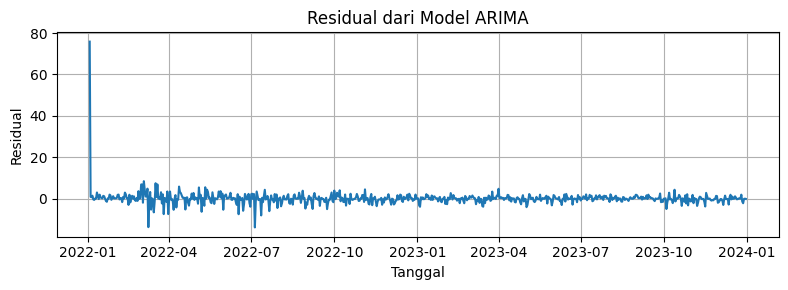

In [ ]:
# Plot residual model1 pada data latih
residuals_train = model_fit1.resid
print("\nMemplot residual...")
plt.figure(figsize=(8, 3))
plt.plot(residuals_train.index, residuals_train)
plt.title("Residual dari Model ARIMA")
plt.xlabel("Tanggal")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

###### --Plot ACF dan PACF dari residual --

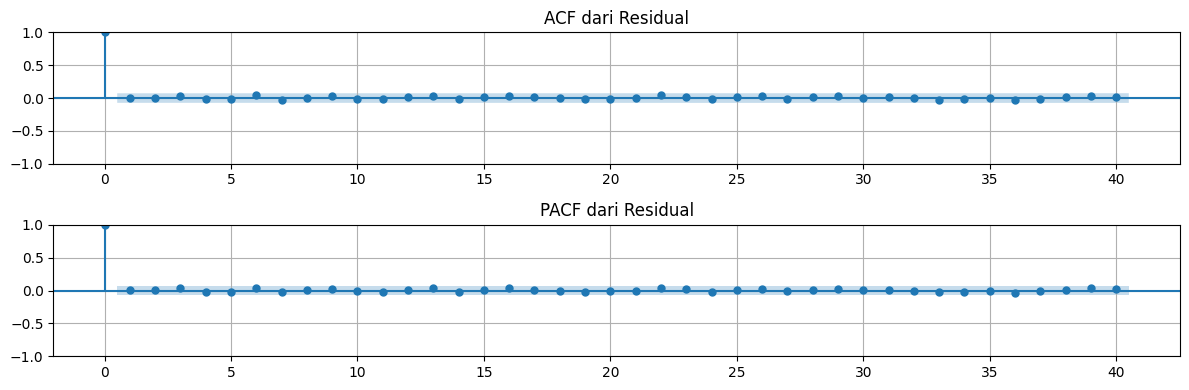

In [ ]:
# Jika residual adalah white noise, ACF dan PACF seharusnya tidak signifikan pada lag > 0
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

plot_acf(residuals_train, lags=40, ax=axes[0])
axes[0].set_title('ACF dari Residual')
axes[0].grid(True)

plot_pacf(residuals_train, lags=40, ax=axes[1])
axes[1].set_title('PACF dari Residual')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Residual adalah white noise, terlihat pada plot ACF dan PACF tidak signifikan pada lag > 0

###### -- Uji Ljung-Box pada Residual --

In [ ]:
# Menguji keberadaan autokorelasi pada residual
# Hipotesis Nol (H0): Residual adalah white noise (tidak ada autokorelasi)
# Hipotesis Alternatif (H1): Residual BUKAN white noise (ada autokorelasi)

print("Melakukan Uji Ljung-Box pada Residual... \n")

# statsmodels.stats.diagnostic.acorr_ljungbox mengembalikan tuple (statistik, pvalue)

ljungbox_result = acorr_ljungbox(residuals_train, lags=[10, 20, 40, 60])

print("Hasil Uji Ljung-Box:")

# Hasil acorr_ljungbox di statsmodels versi baru adalah DataFrame
print(ljungbox_result)

# Interpretasi ringkas: Jika p-value untuk semua lag signifikan (<= 0.05),
# maka model BELUM cukup menangkap autokorelasi.
# Jika p-value tinggi (> 0.05) untuk semua lag, model sudah cukup baik.

print("\nInterpretasi Uji Ljung-Box:")
if any(ljungbox_result['lb_pvalue'] <= 0.05):
    print("❌ Uji Ljung-Box menolak hipotesis nol (p-value <= 0.05) untuk beberapa lag.")
    print("Ini menunjukkan masih ada autokorelasi signifikan pada residual.")
    print("Model mungkin belum sepenuhnya menangkap pola dalam data.")
else:
    print("✅ Uji Ljung-Box gagal menolak hipotesis nol (p-value > 0.05) untuk semua lag yang diuji.")
    print("Ini menunjukkan residual menyerupai white noise, model cukup baik dalam menangkap autokorelasi.")


Melakukan Uji Ljung-Box pada Residual... 

Hasil Uji Ljung-Box:
      lb_stat  lb_pvalue
10   3.781341   0.956672
20   6.375512   0.998286
40  13.279682   0.999978
60  26.579236   0.999944

Interpretasi Uji Ljung-Box:
✅ Uji Ljung-Box gagal menolak hipotesis nol (p-value > 0.05) untuk semua lag yang diuji.
Ini menunjukkan residual menyerupai white noise, model cukup baik dalam menangkap autokorelasi.


**Residual** adalah white noise semakin diperkuat kembali secara statistik dari uji Ljung-Box dengan hasil gagal menolak hipotesis nol (p-value > 0.05) untuk semua lag yang diuji. --

Ini menunjukkan residual menyerupai white noise, model cukup baik dalam menangkap autokorelasi.

###### -- Menguji Normalitas Residual --

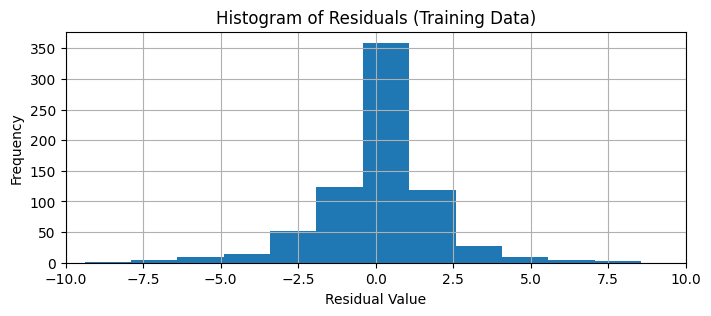

In [ ]:
# Plot distribusi residual pada data latih
plt.figure(figsize=(8, 3))
residuals_train.hist(bins=60)
plt.title('Histogram of Residuals (Training Data)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.xlim([-10, 10])
plt.show()

Dari plot, terlihat bahwa residual berdistribusi tampak berdistribusi normal.

###### --- Uji Jarque-Bera pada Residual ---

In [ ]:
# Hipotesis Nol (H0): Residual terdistribusi normal
# Hipotesis Alternatif (H1): Residual TIDAK terdistribusi normal
print("Melakukan Uji Jarque-Bera pada Residual...\n")

from statsmodels.stats.stattools import jarque_bera

jb_statistic, jb_pvalue, skewness, kurtosis = jarque_bera(residuals_train)

print(f"Statistik Jarque-Bera: {jb_statistic:.4f}")
print(f"Nilai p-value Jarque-Bera: {jb_pvalue:.4f}")

# Interpretasi ringkas Uji Jarque-Bera:
# Hipotesis Nol (H0): Residual terdistribusi normal
# Hipotesis Alternatif (H1): Residual TIDAK terdistribusi normal
# [2]

print("\nInterpretasi Uji Jarque-Bera:")
if jb_pvalue <= 0.05:
    print("❌ Uji Jarque-Bera menolak hipotesis nol (p-value <= 0.05).")
    print("Ini menunjukkan residual TIDAK terdistribusi secara normal.")
    print("Asumsi normalitas residual pada model ini mungkin tidak terpenuhi.")
else:
    print("✅ Uji Jarque-Bera gagal menolak hipotesis nol (p-value > 0.05).")
    print("Ini menunjukkan residual kemungkinan terdistribusi secara normal.")
    print("Asumsi normalitas residual pada model ini terpenuhi.")

Melakukan Uji Jarque-Bera pada Residual...

Statistik Jarque-Bera: 3123995.5155
Nilai p-value Jarque-Bera: 0.0000

Interpretasi Uji Jarque-Bera:
❌ Uji Jarque-Bera menolak hipotesis nol (p-value <= 0.05).
Ini menunjukkan residual TIDAK terdistribusi secara normal.
Asumsi normalitas residual pada model ini mungkin tidak terpenuhi.


Akan tetapi, pada Uji Jarque-Bera pada residual

Uji Jarque-Bera menolak hipotesis nol (p-value <= 0.05).

Ini menunjukkan residual TIDAK terdistribusi secara normal.

Asumsi normalitas residual pada model ini mungkin tidak terpenuhi.

---

Akan tetapi, ini menarik. Jika kita ambil dari `model1_summary`,

statistik Jarque-Bera (JB): 2168.01

Sehingga, Prob(JB): 0.00. yakni tetap sama-sama menolak hipotesis nol dan menunjukkan residual tidak berdistribusi normal.

Tapi, dari library `from statsmodels.stats.stattools import jarque_bera` kita peroleh statistik Jarque-Bera: 3123995.5155.

Meskipun sama-sama menolak hipotesis nol. tapi, mengapa memberikan statistik yang berbeda?

---
Hal ini disebabkan dari summary model fit dihitung berdasarkan residual baku (standardized residuals) dari model ARIMA yang telah disesuaikan. Residual baku adalah residual yang dibagi dengan estimasi deviasi standar residual. Tujuannya adalah untuk menormalisasi residual agar variabilitasnya seragam.

Sedangkan, library di atas berdasarkan residual mentah (raw residuals) yang kita masukkan ke dalamnya (residuals_train). Residual mentah adalah selisih langsung antara nilai aktual dan nilai prediksi dari model pada data latih.

Diagnostik residual menggunakan residual baku dari ringkasan model lebih relevan. Hal ini karena residual baku telah mempertimbangkan heteroskedastisitas (jika ada) dalam proses estimasi model, memberikan pandangan yang lebih akurat tentang apakah sisaan model, setelah mempertimbangkan dinamika varians, masih menunjukkan distribusi normal.

Hal ini mengindikasikan memperkuat temuan heteroskedastisitas dari Uji ARCH dan mendukung eksplorasi model yang dapat menangani variabilitas yang tidak konstan, seperti model ARCH/GARCH, atau transformasi data.

---
Lalu, kenapa pada plot tampak seperti berdistribusi normal?

Mudah saja, kalau kita overlay normal distribusi, maka akan terlihat, kalau plot juga menunjukkan tidak berdistribusi normal.

---

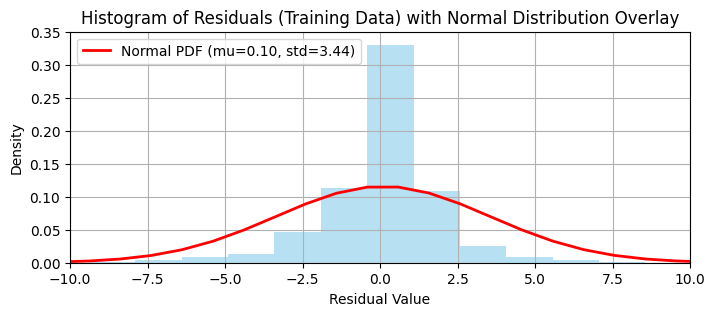

In [ ]:
# Plot distribusi residual lebih tinggi
plt.figure(figsize=(8, 3))
residuals_train.hist(bins=60, density=True, alpha=0.6, color='skyblue')
plt.title('Histogram of Residuals (Training Data) with Normal Distribution Overlay')
plt.xlabel('Residual Value')
plt.ylabel('Density')

# Hitung parameter distribusi normal dari residual
mu, std = norm.fit(residuals_train)

# Buat kurva distribusi normal
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Plot kurva distribusi normal
plt.plot(x, p, 'red', linewidth=2, label=f'Normal PDF (mu={mu:.2f}, std={std:.2f})')

plt.xlim([-10, 10])
plt.ylim([0, 0.35])

plt.legend()
plt.grid(True)
plt.show()

###### --- Uji Heteroskedasticity (ARCH Test) pada Residual ---

Meskipun dari temuan normalitas residual telah menunjukkan adanya temuan heterokedastisitas pada data.

untuk memperkuat secara statistik, kita akan menguji heterokedastisitas pada residual

In [ ]:
# Menguji apakah varians residual konstan (homoskedastisitas)

# Hipotesis Nol (H0): Residual adalah homoskedastis (varians konstan)
# Hipotesis Alternatif (H1): Residual adalah heteroskedastis (varians tidak konstan / ada efek ARCH)

print("Melakukan Uji Heteroskedasticity (ARCH Test) pada Residual...\n")

# het_arch mengembalikan tuple (statistik lagrange multiplier, p-value, f-statistic, p-value f-statistic)

arch_test_result = het_arch(residuals_train, nlags=10)
lm_statistic, lm_pvalue, f_statistic, f_pvalue = arch_test_result

print(f"Lagrange Multiplier Statistic: {lm_statistic:.4f}")
print(f"Nilai p-value (Lagrange Multiplier): {lm_pvalue:.4f}")
print(f"F-Statistic: {f_statistic:.4f}")
print(f"Nilai p-value (F-Statistic): {f_pvalue:.4f}")

print("\nInterpretasi Uji Heteroskedasticity (ARCH Test):")
if lm_pvalue <= 0.05:
    print("⚠️ Uji Heteroskedasticity menolak hipotesis nol (p-value <= 0.05).")
    print("Ini menunjukkan residual TIDAK homoskedastis (varians tidak konstan).")
    print("Ada indikasi efek ARCH (volatilitas berkelompok).")
else:
    print("✅ Uji Heteroskedasticity gagal menolak hipotesis nol (p-value > 0.05).")
    print("Ini menunjukkan residual cenderung homoskedastis (varians konstan).")

Melakukan Uji Heteroskedasticity (ARCH Test) pada Residual...

Lagrange Multiplier Statistic: 80.7370
Nilai p-value (Lagrange Multiplier): 0.0000
F-Statistic: 8.9572
Nilai p-value (F-Statistic): 0.0000

Interpretasi Uji Heteroskedasticity (ARCH Test):
⚠️ Uji Heteroskedasticity menolak hipotesis nol (p-value <= 0.05).
Ini menunjukkan residual TIDAK homoskedastis (varians tidak konstan).
Ada indikasi efek ARCH (volatilitas berkelompok).


Benar saja, sesuai dengan EDA dan Normalitas sebelumnya.

Nilai statistik Lagrange multiplier diperoleh: `80.74`

sehingga, p-value (`0.00` < `0.05`) sangat kecil dan akhirnya menolak hipotesis nol.

Oleh karena itu, Model menunjukkan Residual tidak homoskedastisitas (varians tidak konstan).
Ada indikasi efek ARCH (volatilitas berkelompok).

##### **b. Evaluasi Performansi pada Data Uji:**

Kita akan menggunakan model yang telah dilatih pada data latih untuk melakukan peramalan pada periode yang sesuai dengan data uji.


In [ ]:
# --- Membuat Prediksi pada Data Uji ---
print("Membuat prediksi pada data uji...")

# Lakukan pengujian
n_forecast_steps = len(data_uji)
print(f"Prediksi dibuat untuk {n_forecast_steps} langkah ke depan.")

forecast_test = model_fit1.forecast(steps = n_forecast_steps)

# Nama kolom target dari data uji untuk perbandingan
actual_values = data_uji[target_column]

# Tampilkan hasil peramalan pada data uji
print("\nForecasted Prices on Test Data:")
print(forecast_test)

# --- Evaluasi Model ---
print("\nEvaluasi Model:")
mae = mean_absolute_error(actual_values, forecast_test)
mse = mean_squared_error(actual_values, forecast_test)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - forecast_test) / (actual_values + 1e-8))) * 100

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')

Membuat prediksi pada data uji...
Prediksi dibuat untuk 274 langkah ke depan.

Forecasted Prices on Test Data:
2024-01-01    72.047578
2024-01-02    72.117771
2024-01-03    72.174602
2024-01-04    72.220614
2024-01-05    72.257868
                ...    
2024-09-26    72.416315
2024-09-27    72.416315
2024-09-28    72.416315
2024-09-29    72.416315
2024-09-30    72.416315
Freq: D, Name: predicted_mean, Length: 274, dtype: float64

Evaluasi Model:
Mean Absolute Error (MAE): 5.4927
Mean Squared Error (MSE): 41.7104
Root Mean Squared Error (RMSE): 6.4584
Mean Absolute Percentage Error (MAPE): 6.9405%


Evaluasi Model:

- Mean Absolute Error (MAE): 5.4927
- Mean Squared Error (MSE): 41.7104
- Root Mean Squared Error (RMSE): 6.4584
- Mean Absolute Percentage Error (MAPE): 6.9405%

###### Visualisasi

**Untuk memvisualisasikan data aktual vs. peramalan pada periode uji:**


Menampilkan visualisasi prediksi vs aktual...


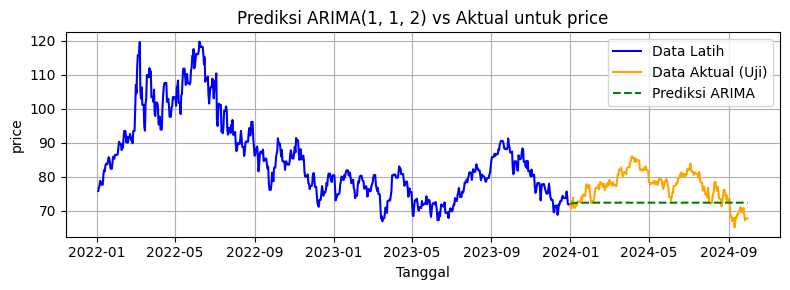


Untuk lebih detail, kita perbesar ...


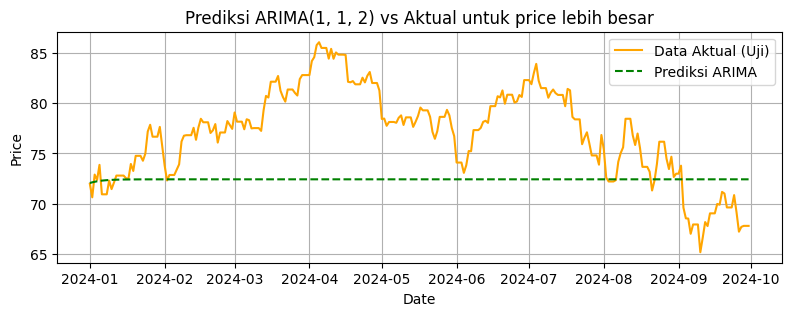

In [ ]:
# Plot data aktual pada periode uji dan peramalan

print("Menampilkan visualisasi prediksi vs aktual...")

plt.figure(figsize=(8, 3))

# Plot data historis (latih dan uji)
plt.plot(data_latih.index, data_latih[target_column], label='Data Latih', color='blue')
plt.plot(data_uji.index, actual_values, label='Data Aktual (Uji)', color='orange')
plt.plot(forecast_test.index, forecast_test, label='Prediksi ARIMA', color='green', linestyle='--')

# Tambahkan judul dan label sumbu
plt.title(f'Prediksi ARIMA(1, 1, 2) vs Aktual untuk {target_column}')
plt.xlabel('Tanggal')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print()
print('Untuk lebih detail, kita perbesar ...')

# untuk lebih zoom
plt.figure(figsize=(9.35, 3))
plt.plot(data_uji.index, actual_values, label='Data Aktual (Uji)', color='orange')
plt.plot(data_uji.index, forecast_test, label='Prediksi ARIMA', color='green', linestyle='--')
plt.title(f'Prediksi ARIMA(1, 1, 2) vs Aktual untuk {target_column} lebih besar')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Sesuai dugaan, prediksi ARIMA kita menjadi konstan setelah titik tertentu, ini adalah perilaku yang umum, terutama untuk model ARIMA sederhana (seperti ARIMA(1,1,2) tanpa komponen musiman atau regresor eksternal) ketika melakukan prediksi untuk banyak langkah ke depan.

hal ini disebabkan model **Memprediksi Kecenderungan Kembali ke Rata-rata** dan **Konvergensi Model ke Keadaan Stasioner**. Sebelumnya kita sudah menyadari bahwa residual tidak berdistribusi normal dan adanya heterokedastisitas pada data.

Sehingga, ini wajar ditemukan.

Kita cukupkan model ARIMA di sini dan kita akan lanjutkan pada section berikutnya terkait SARIMA, Transformasi, dan ARCH-GARCH model.

# Kesimpulan

Dari analisis yang telah dilakukan menggunakan model ARIMA(1,1,2) untuk memprediksi harga Crude Oil WTI:

1.  **Data Preprocessing:** Data berhasil dimuat, dibersihkan (mengatasi missing values dengan backward fill), dan diatur dengan indeks tanggal serta frekuensi harian.
2.  **EDA dan Stasioneritas:** Analisis awal menunjukkan data asli non-stasioner dengan adanya tren dan variansi yang tidak konstan. Proses differencing orde pertama berhasil membuat data menjadi stasioner, yang dikonfirmasi oleh Uji ADF. Analisis ACF dan PACF pada data yang didifferencing memberikan indikasi awal untuk ordo (p,q) model ARIMA.
3.  **Pemodelan ARIMA:** Model ARIMA(1,1,2) dipilih berdasarkan analisis ACF/PACF dan perbandingan dengan ordo lain berdasarkan kriteria informasi (AIC/BIC), menunjukkan kinerja yang relatif baik dalam menangkap struktur autokorelasi pada data latih.
4.  **Diagnostik Residual:**
    *   Uji Ljung-Box menunjukkan bahwa residual model menyerupai white noise, mengindikasikan bahwa model telah berhasil menangkap sebagian besar autokorelasi.
    *   Namun, uji Jarque-Bera dan visualisasi histogram menunjukkan bahwa residual **tidak berdistribusi secara normal**.
    *   Uji Heteroskedasticity (ARCH Test) menunjukkan adanya bukti **heteroskedastisitas** pada residual (varians tidak konstan). Temuan ini konsisten dengan observasi pada tahap EDA.
5. **Evaluasi Peramalan pada Data Uji:** Model ARIMA(1,1,2) mampu memberikan peramalan pada data uji. Kinerja model pada data uji dievaluasi menggunakan metrik berikut:
    *   Mean Absolute Error (MAE): 5.4927
    *   Mean Squared Error (MSE): 41.7104
    *   Root Mean Squared Error (RMSE): 6.4584
    *   Mean Absolute Percentage Error (MAPE): 6.9405%

    Seperti yang umum terjadi pada model ARIMA dasar untuk peramalan multi-langkah, prediksi cenderung menjadi konstan seiring bertambahnya periode peramalan. Metrik evaluasi memberikan gambaran kuantitatif tentang akurasi model pada data uji.

**Langkah Selanjutnya:**

Temuan bahwa residual tidak normal dan adanya heteroskedastisitas mengindikasikan bahwa model ARIMA(1,1,2) dasar mungkin belum sepenuhnya optimal dalam menangani karakteristik data Crude Oil WTI, terutama volatilitas yang berfluktuasi. Untuk meningkatkan kinerja peramalan, beberapa langkah selanjutnya dapat dipertimbangkan:

*   **Eksplorasi Model yang Menangani Volatilitas:** Pertimbangkan penerapan model GARCH (Generalized Autoregressive Conditional Heteroskedasticity) atau model kombinasi seperti ARIMA-GARCH yang secara eksplisit memodelkan varians yang tidak konstan.
*   **Transformasi Data:** Mencoba transformasi data target (misalnya, log transformasi) untuk menstabilkan varians sebelum menerapkan model ARIMA.


##### Simpan Model untuk Pengukuran Evaluasi di Masa Depan dengan Data Baru

Setelah model terbaik dipilih dan dievaluasi, disarankan untuk menyimpannya agar dapat digunakan kembali di masa depan untuk peramalan pada data baru tanpa perlu melatih ulang.

Kita akan menggunakan pustaka `pickle` untuk serialisasi objek model Python.

In [ ]:
import pickle

In [ ]:
# Nama file
filename = 'arima_crude_oil_model.pkl'

# Simpan model ke dalam file menggunakan pickle
try:
    with open(filename, 'wb') as file:
        pickle.dump(model_fit1, file)
    print(f"Model berhasil disimpan ke dalam file: {filename}")
except Exception as e:
    print(f"Terjadi kesalahan saat menyimpan model: {e}")

Model berhasil disimpan ke dalam file: arima_crude_oil_model.pkl
